In [10]:
import os
import ee
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import stats

In [11]:
cwd = "c:\\Users\\m1865\\Desktop\\DISC"
cwd_Images_Raw = cwd + "\\Sentinel-2 Images Raw"
cwd_Images_Processed = cwd + "\\Sentinel-2 Images Processed"

In [12]:
# Create a project called "ee-sentinel-2temporal-nir"
# Google Account is jiawei.gao.polimi@gmail.com
ee.Authenticate(force = False)
ee.Initialize(project='ee-sentinel-2temporal-nir')

In [13]:
date_Start = "2023-01-01"
date_End = "2023-12-31"

In [14]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask)

In [15]:
dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate(date_Start, date_End)
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))
    .map(mask_s2_clouds)
)

In [16]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms').dt.date

    # Keep the columns of interest.
    df = df[['datetime',  *list_of_bands]]

    return df

There are 64 dates available for IT-SR2!
2023-01-26
2023-01-28
2023-02-05
2023-02-07
2023-02-10
2023-02-12
2023-02-20
2023-03-02
2023-03-12
2023-03-14
2023-03-24
2023-03-27
2023-04-01
2023-04-06
2023-04-08
2023-04-16
2023-04-21
2023-04-26
2023-05-06
2023-05-11
2023-05-23
2023-05-26
2023-05-28
2023-06-02
2023-06-07
2023-06-12
2023-06-15
2023-06-17
2023-06-25
2023-06-27
2023-07-02
2023-07-05
2023-07-07
2023-07-10
2023-07-15
2023-07-17
2023-07-25
2023-07-27
2023-08-06
2023-08-11
2023-08-14
2023-08-16
2023-08-19
2023-08-21
2023-08-24
2023-08-26
2023-09-05
2023-09-08
2023-09-10
2023-09-15
2023-09-23
2023-09-25
2023-09-30
2023-10-03
2023-10-08
2023-10-10
2023-10-28
2023-11-07
2023-11-24
2023-11-29
2023-12-17
2023-12-19
2023-12-22
2023-12-24


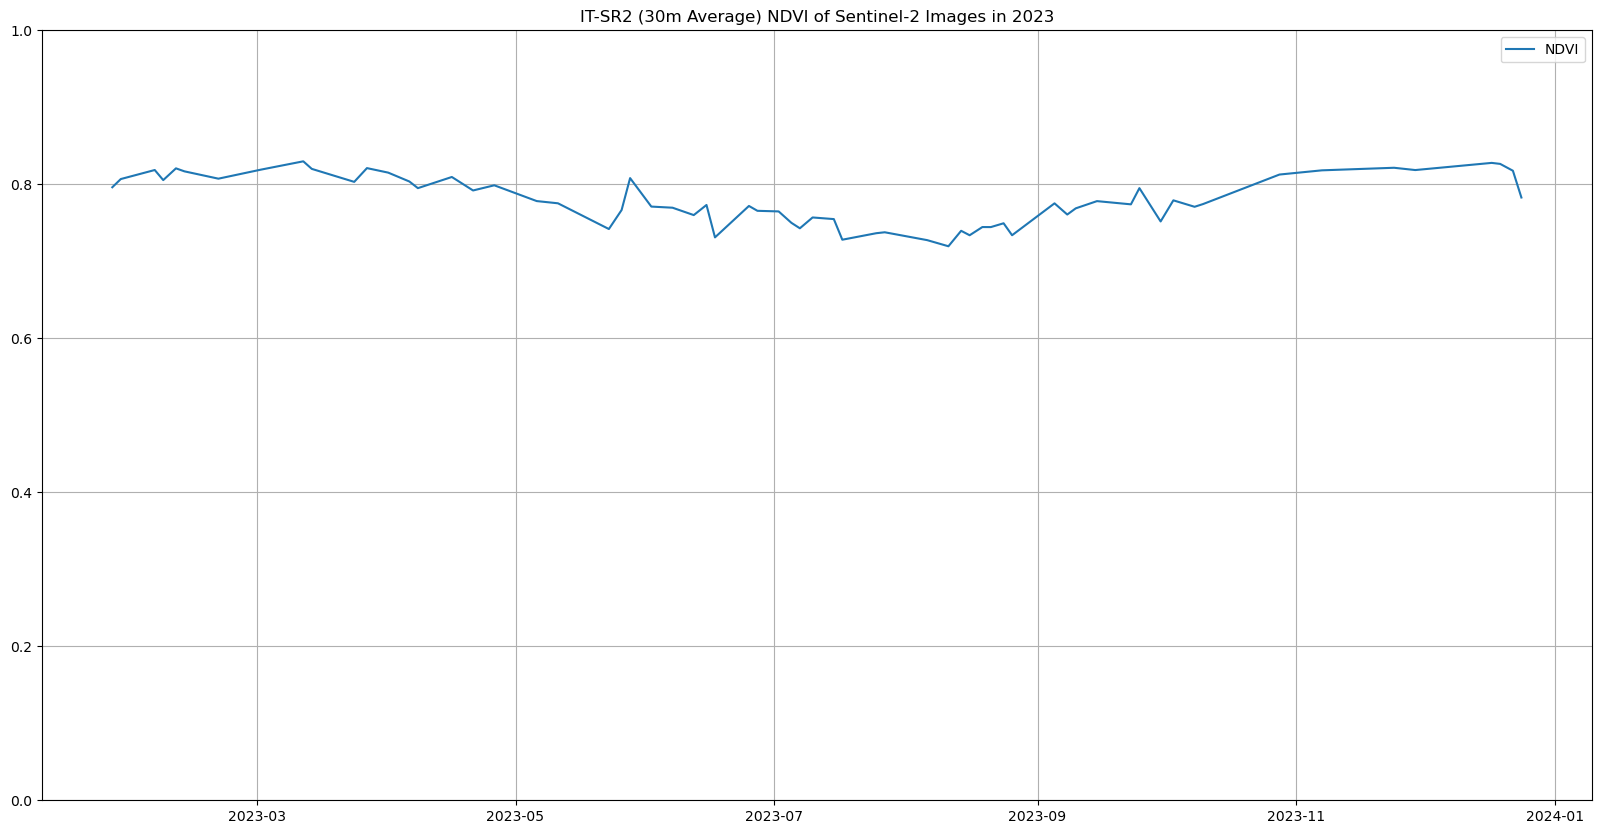

In [31]:
df = pd.read_csv(cwd + "\\Site.csv")
for i in range(df.shape[0]):
    name_Site = df.loc[i,'Site']
    if name_Site == "IT-SR2":
        gdf = gpd.read_file(cwd_Images_Processed + "\\" + name_Site + "\\30m.shp")
        gdf = gdf.to_crs("EPSG:4326")
        bounds = gdf.bounds.values.reshape(-1)
        roi = ee.Geometry.Rectangle([bounds[0],bounds[1],bounds[2],bounds[3]])
        a = dataset.getRegion(roi,10).getInfo()
        s2_RoI_B8 = ee_array_to_df(a,["B4",'B8'])
        s2_RoI_B8['NDVI'] = (s2_RoI_B8['B8'] - s2_RoI_B8['B4']) / (s2_RoI_B8['B8'] + s2_RoI_B8['B4'])
        s2_RoI_B8.sort_values('datetime')
        m = s2_RoI_B8[np.abs(stats.zscore(s2_RoI_B8['B8'])) < 1]
        m = m[np.abs(stats.zscore(m['B4'])) < 1]
        m = m[np.abs(stats.zscore(m['NDVI'])) < 1]
        df_Merge_Mean = m.groupby("datetime").mean().reset_index(drop = False)  
        print(f"There are {df_Merge_Mean.shape[0]} dates available for {name_Site}!")
        for j in range(df_Merge_Mean. shape[0]):
            print(df_Merge_Mean.loc[j,"datetime"])
        # plt.figure(figsize = (20,10))
        # plt.title(f"{name_Site} (30m Average) Near Infrared Values of Sentinel-2 Images in 2023")
        # plt.plot(df_Merge_Mean['datetime'], df_Merge_Mean['B8'], label = "NIR")
        # plt.ylim(0,10000)
        # plt.legend()
        # plt.grid()
        # plt.savefig(cwd_Images_Processed + "\\" + name_Site + "\\TimeSeries - NIR.png")
        # plt.close()
        plt.figure(figsize = (20,10))
        plt.title(f"{name_Site} (30m Average) NDVI of Sentinel-2 Images in 2023")
        plt.plot(df_Merge_Mean['datetime'], df_Merge_Mean['NDVI'], label = "NDVI")
        plt.ylim(0,1)
        plt.legend()
        plt.grid()
        # plt.savefig(cwd_Images_Processed + "\\" + name_Site + "\\TimeSeries - NDVI.png")
        # plt.close()
        break